In [5]:
# Install required packages
!pip install -q lightgbm shap joblib scikit-learn pandas numpy matplotlib seaborn

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_fscore_support, roc_curve, auc
)
import lightgbm as lgb
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✅ All libraries imported successfully")
print(f"Python Environment Ready | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully
Python Environment Ready | 2026-01-29 05:19:16


In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define project paths
BASE_PATH = Path('/content/drive/MyDrive/ids_project')
RAW_DATA_PATH = BASE_PATH / 'raw_data'
PROCESSED_DATA_PATH = BASE_PATH / 'processed_data'
ARTIFACTS_PATH = BASE_PATH / 'artifacts'

# Create directory structure
for path in [RAW_DATA_PATH, PROCESSED_DATA_PATH, ARTIFACTS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

print("\n📁 Directory Structure Created:")
print(f"  └─ Base: {BASE_PATH}")
print(f"     ├─ raw_data/")
print(f"     ├─ processed_data/")
print(f"     └─ artifacts/")
print("\n✅ Google Drive mounted successfully")

Mounted at /content/drive

📁 Directory Structure Created:
  └─ Base: /content/drive/MyDrive/ids_project
     ├─ raw_data/
     ├─ processed_data/
     └─ artifacts/

✅ Google Drive mounted successfully


In [8]:
# Generate sample dataset for demonstration
# In production, replace this with your actual dataset loading

def generate_sample_ids_data(n_samples=10000):
    """
    Generate synthetic IDS dataset for demonstration.
    In production, replace this with actual data loading.
    """
    np.random.seed(42)

    # Generate timestamps
    start_time = datetime(2026, 1, 29, 0, 0, 0)
    timestamps = [start_time + timedelta(seconds=i*10) for i in range(n_samples)]

    # Normal traffic (80%)
    n_normal = int(n_samples * 0.8)
    normal_data = {
        'timestamp': timestamps[:n_normal],
        'src_ip': [f"192.168.1.{np.random.randint(1, 255)}" for _ in range(n_normal)],
        'dst_ip': [f"10.0.{np.random.randint(0, 255)}.{np.random.randint(1, 255)}" for _ in range(n_normal)],
        'src_port': np.random.randint(1024, 65535, n_normal),
        'dst_port': np.random.choice([80, 443, 22, 21, 25, 53, 3389], n_normal),
        'protocol': np.random.choice(['TCP', 'UDP', 'ICMP'], n_normal, p=[0.7, 0.25, 0.05]),
        'bytes_sent': np.random.lognormal(6, 2, n_normal).astype(int),
        'bytes_received': np.random.lognormal(7, 2, n_normal).astype(int),
        'packets_sent': np.random.poisson(20, n_normal),
        'packets_received': np.random.poisson(25, n_normal),
        'duration': np.random.exponential(5, n_normal),
        'label': ['BENIGN'] * n_normal
    }

    # Attack traffic (20%)
    n_attack = n_samples - n_normal
    attack_types = ['DDoS', 'Port_Scan', 'Brute_Force', 'SQL_Injection', 'XSS']
    attack_data = {
        'timestamp': timestamps[n_normal:],
        'src_ip': [f"192.168.{np.random.randint(1, 255)}.{np.random.randint(1, 255)}" for _ in range(n_attack)],
        'dst_ip': [f"10.0.0.{np.random.randint(1, 50)}" for _ in range(n_attack)],
        'src_port': np.random.randint(1, 65535, n_attack),
        'dst_port': np.random.choice([80, 443, 22, 3389, 8080], n_attack),
        'protocol': np.random.choice(['TCP', 'UDP'], n_attack, p=[0.9, 0.1]),
        'bytes_sent': np.random.lognormal(4, 1.5, n_attack).astype(int),  # Smaller packets
        'bytes_received': np.random.lognormal(3, 1, n_attack).astype(int),  # Less response
        'packets_sent': np.random.poisson(100, n_attack),  # More packets
        'packets_received': np.random.poisson(10, n_attack),  # Fewer responses
        'duration': np.random.exponential(0.5, n_attack),  # Shorter duration
        'label': np.random.choice(attack_types, n_attack)
    }

    # Combine and shuffle
    df_normal = pd.DataFrame(normal_data)
    df_attack = pd.DataFrame(attack_data)
    df = pd.concat([df_normal, df_attack], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

# Generate or load dataset
print("Loading dataset...")

# Try to load from Drive first
dataset_path = RAW_DATA_PATH / 'network_traffic.csv'

if dataset_path.exists():
    df = pd.read_csv(dataset_path)
    print(f"✅ Loaded existing dataset from {dataset_path}")
else:
    df = generate_sample_ids_data(n_samples=10000)
    df.to_csv(dataset_path, index=False)
    print(f"✅ Generated sample dataset and saved to {dataset_path}")
    print("   (Replace with your actual IDS dataset for production use)")

Loading dataset...
✅ Generated sample dataset and saved to /content/drive/MyDrive/ids_project/raw_data/network_traffic.csv
   (Replace with your actual IDS dataset for production use)



DATASET OVERVIEW

📊 Dataset Shape: 10,000 rows × 12 columns

📋 Column Names:
['timestamp', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'bytes_sent', 'bytes_received', 'packets_sent', 'packets_received', 'duration', 'label']

🔍 First 5 rows:


,timestamp,src_ip,dst_ip,src_port,dst_port,protocol,bytes_sent,bytes_received,packets_sent,packets_received,duration,label
0,2026-01-29 17:22:00,192.168.1.187,10.0.106.24,26730,3389,UDP,465,45225,27,20,1.358798,BENIGN
1,2026-01-29 13:00:40,192.168.1.94,10.0.7.13,28244,3389,TCP,1049,95682,25,25,2.451870,BENIGN
2,2026-01-29 04:48:30,192.168.1.162,10.0.8.62,8043,443,TCP,151,548,21,22,4.169700,BENIGN
3,2026-01-29 13:10:20,192.168.1.118,10.0.211.111,58474,25,TCP,6768,12,17,31,0.180758,BENIGN
4,2026-01-29 12:33:30,192.168.1.1,10.0.237.195,30628,22,UDP,230,1321,28,25,3.230147,BENIGN



📈 Data Types:
timestamp           datetime64[ns]
src_ip                      object
dst_ip                      object
src_port                     int64
dst_port                     int64
protocol                    object
bytes_sent                   int64
bytes_received               int64
packets_sent                 int64
packets_received             int64
duration                   float64
label                       object
dtype: object

⚠️  Missing Values:
No missing values found ✅

🎯 Label Distribution:
label
BENIGN           8000
DDoS              413
XSS               409
Brute_Force       403
Port_Scan         392
SQL_Injection     383
Name: count, dtype: int64

   Attack Rate: 20.00%


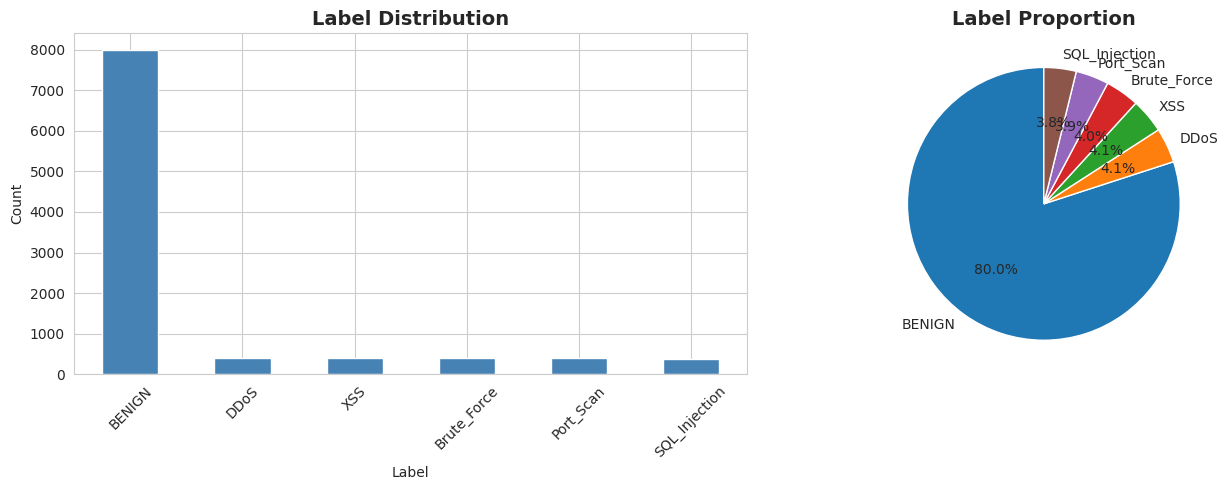

In [9]:
# Dataset Overview
print("\n" + "="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"\n📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n📋 Column Names:")
print(df.columns.tolist())

print(f"\n🔍 First 5 rows:")
display(df.head())

print(f"\n📈 Data Types:")
print(df.dtypes)

print(f"\n⚠️  Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found ✅")

# Label distribution if present
if 'label' in df.columns:
    print(f"\n🎯 Label Distribution:")
    label_counts = df['label'].value_counts()
    print(label_counts)
    print(f"\n   Attack Rate: {(label_counts.sum() - label_counts.get('BENIGN', 0)) / label_counts.sum() * 100:.2f}%")

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot
    label_counts.plot(kind='bar', ax=ax[0], color='steelblue')
    ax[0].set_title('Label Distribution', fontsize=14, fontweight='bold')
    ax[0].set_xlabel('Label')
    ax[0].set_ylabel('Count')
    ax[0].tick_params(axis='x', rotation=45)

    # Pie chart
    label_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', startangle=90)
    ax[1].set_title('Label Proportion', fontsize=14, fontweight='bold')
    ax[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [10]:
# Data cleaning
print("\n🔧 Data Cleaning...")

# Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
print(f"   Removed {initial_rows - len(df):,} duplicate rows")

# Handle missing values
if df.isnull().sum().sum() > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    print(f"   Filled missing values in numeric columns with median")

# Remove invalid rows (negative values where inappropriate)
numeric_cols = ['bytes_sent', 'bytes_received', 'packets_sent', 'packets_received', 'duration']
for col in numeric_cols:
    if col in df.columns:
        before = len(df)
        df = df[df[col] >= 0]
        removed = before - len(df)
        if removed > 0:
            print(f"   Removed {removed} rows with negative {col}")

print(f"\n✅ Cleaned dataset shape: {df.shape}")


🔧 Data Cleaning...
   Removed 0 duplicate rows

✅ Cleaned dataset shape: (10000, 12)


In [11]:
# Convert timestamp to datetime if it's a string
if df['timestamp'].dtype == 'object':
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

print("🔬 Feature Engineering Pipeline\n")
print("Creating time-window based aggregation features...")

# Set time window (1 minute)
WINDOW_SIZE = '1min'

# Create time window groups
df['time_window'] = df['timestamp'].dt.floor(WINDOW_SIZE)

# Basic features
features_df = df.copy()

# 1. Byte-based features
features_df['bytes_in'] = features_df['bytes_received']
features_df['bytes_out'] = features_df['bytes_sent']
features_df['total_bytes'] = features_df['bytes_in'] + features_df['bytes_out']

# 2. Packet-based features
features_df['packets_in'] = features_df['packets_received']
features_df['packets_out'] = features_df['packets_sent']
features_df['total_packets'] = features_df['packets_in'] + features_df['packets_out']

# 3. Average packet size
features_df['avg_packet_size'] = features_df['total_bytes'] / (features_df['total_packets'] + 1e-6)

# 4. Outbound/Inbound ratio
features_df['outbound_inbound_ratio'] = features_df['bytes_out'] / (features_df['bytes_in'] + 1e-6)

# 5. Packet rate (packets per second)
features_df['packet_rate'] = features_df['total_packets'] / (features_df['duration'] + 1e-6)

# 6. Byte rate (bytes per second)
features_df['byte_rate'] = features_df['total_bytes'] / (features_df['duration'] + 1e-6)

print("✓ Basic traffic features created")

# Time-window aggregation features
print("\nCreating time-window aggregation features...")

# Group by source IP and time window
src_window_groups = features_df.groupby(['src_ip', 'time_window'])

# Aggregate features
window_agg = src_window_groups.agg({
    'dst_ip': 'nunique',
    'dst_port': 'nunique',
    'packets_out': 'sum',
    'bytes_out': 'sum',
    'duration': 'mean'
}).reset_index()

window_agg.columns = [
    'src_ip', 'time_window', 'unique_destination_ips',
    'destination_port_count', 'window_packets_out',
    'window_bytes_out', 'avg_duration'
]

# Merge back to main dataframe
features_df = features_df.merge(
    window_agg,
    on=['src_ip', 'time_window'],
    how='left'
)

print("✓ Time-window aggregation features created")

# Protocol-based features
print("\nCreating protocol-based features...")

# One-hot encode protocol
protocol_dummies = pd.get_dummies(features_df['protocol'], prefix='protocol')
features_df = pd.concat([features_df, protocol_dummies], axis=1)

print("✓ Protocol features created")

# Port-based features
print("\nCreating port-based features...")

# Common ports
COMMON_PORTS = [80, 443, 22, 21, 25, 53, 3389, 8080]
features_df['is_common_dst_port'] = features_df['dst_port'].isin(COMMON_PORTS).astype(int)
features_df['is_privileged_src_port'] = (features_df['src_port'] < 1024).astype(int)

print("✓ Port features created")

# Statistical features
print("\nCreating statistical features...")

# Connection count per source IP in time window
conn_counts = features_df.groupby(['src_ip', 'time_window']).size().reset_index(name='connection_count')
features_df = features_df.merge(conn_counts, on=['src_ip', 'time_window'], how='left')

print("✓ Statistical features created")

print(f"\n✅ Feature engineering complete!")
print(f"   Total features: {len([c for c in features_df.columns if c not in ['timestamp', 'src_ip', 'dst_ip', 'time_window', 'label']])}")

🔬 Feature Engineering Pipeline

Creating time-window based aggregation features...
✓ Basic traffic features created

Creating time-window aggregation features...
✓ Time-window aggregation features created

Creating protocol-based features...
✓ Protocol features created

Creating port-based features...
✓ Port features created

Creating statistical features...
✓ Statistical features created

✅ Feature engineering complete!
   Total features: 29


In [12]:
# Select final feature set
FEATURE_COLUMNS = [
    'bytes_in', 'bytes_out', 'total_bytes',
    'packets_in', 'packets_out', 'total_packets',
    'avg_packet_size', 'outbound_inbound_ratio',
    'packet_rate', 'byte_rate',
    'unique_destination_ips', 'destination_port_count',
    'window_packets_out', 'window_bytes_out', 'avg_duration',
    'is_common_dst_port', 'is_privileged_src_port',
    'connection_count', 'duration'
]

# Add protocol dummy columns
protocol_cols = [c for c in features_df.columns if c.startswith('protocol_')]
FEATURE_COLUMNS.extend(protocol_cols)

# Create final feature dataframe
X = features_df[FEATURE_COLUMNS].copy()

# Handle any remaining NaN values
X = X.fillna(0)

# Handle infinite values
X = X.replace([np.inf, -np.inf], 0)

# Encode labels if present
if 'label' in features_df.columns:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(features_df['label'])

    # Create binary label (benign vs attack)
    y_binary = (features_df['label'] != 'BENIGN').astype(int)

    print("\n🎯 Label Encoding:")
    print(f"   Classes: {list(label_encoder.classes_)}")
    print(f"   Binary distribution: {np.bincount(y_binary)}")

    # Save label mapping
    label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
else:
    y = None
    y_binary = None
    label_encoder = None
    label_mapping = None
    print("\n⚠️  No labels found - will use unsupervised learning only")

print(f"\n📊 Feature Matrix Shape: {X.shape}")
print(f"\n📋 Features List ({len(FEATURE_COLUMNS)} features):")
for i, feat in enumerate(FEATURE_COLUMNS, 1):
    print(f"   {i:2d}. {feat}")


🎯 Label Encoding:
   Classes: ['BENIGN', 'Brute_Force', 'DDoS', 'Port_Scan', 'SQL_Injection', 'XSS']
   Binary distribution: [8000 2000]

📊 Feature Matrix Shape: (10000, 22)

📋 Features List (22 features):
    1. bytes_in
    2. bytes_out
    3. total_bytes
    4. packets_in
    5. packets_out
    6. total_packets
    7. avg_packet_size
    8. outbound_inbound_ratio
    9. packet_rate
   10. byte_rate
   11. unique_destination_ips
   12. destination_port_count
   13. window_packets_out
   14. window_bytes_out
   15. avg_duration
   16. is_common_dst_port
   17. is_privileged_src_port
   18. connection_count
   19. duration
   20. protocol_ICMP
   21. protocol_TCP
   22. protocol_UDP


In [13]:
# Save processed features
print("\n💾 Saving processed features...")

# Combine features with labels and metadata
processed_df = X.copy()
if y is not None:
    processed_df['label'] = features_df['label'].values
    processed_df['label_encoded'] = y
processed_df['timestamp'] = features_df['timestamp'].values

# Save to CSV
processed_path = PROCESSED_DATA_PATH / 'processed_features.csv'
processed_df.to_csv(processed_path, index=False)
print(f"   ✓ Saved to: {processed_path}")

# Save feature metadata
feature_metadata = {
    'feature_columns': FEATURE_COLUMNS,
    'n_features': len(FEATURE_COLUMNS),
    'label_mapping': label_mapping,
    'has_labels': y is not None,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'window_size': WINDOW_SIZE
}

metadata_path = PROCESSED_DATA_PATH / 'feature_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"   ✓ Metadata saved to: {metadata_path}")

print("\n✅ Feature engineering pipeline complete!")


💾 Saving processed features...
   ✓ Saved to: /content/drive/MyDrive/ids_project/processed_data/processed_features.csv
   ✓ Metadata saved to: /content/drive/MyDrive/ids_project/processed_data/feature_metadata.json

✅ Feature engineering pipeline complete!



SUPERVISED LEARNING - LightGBM Classifier

📊 Data Split:
   Training:   6,000 samples (60.0%)
   Validation: 2,000 samples (20.0%)
   Test:       2,000 samples (20.0%)

🔧 Training LightGBM model...

✅ Model training complete!

MODEL EVALUATION

📈 Performance Metrics:
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000
   ROC-AUC:   1.0000

📊 Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      1600
      ATTACK       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



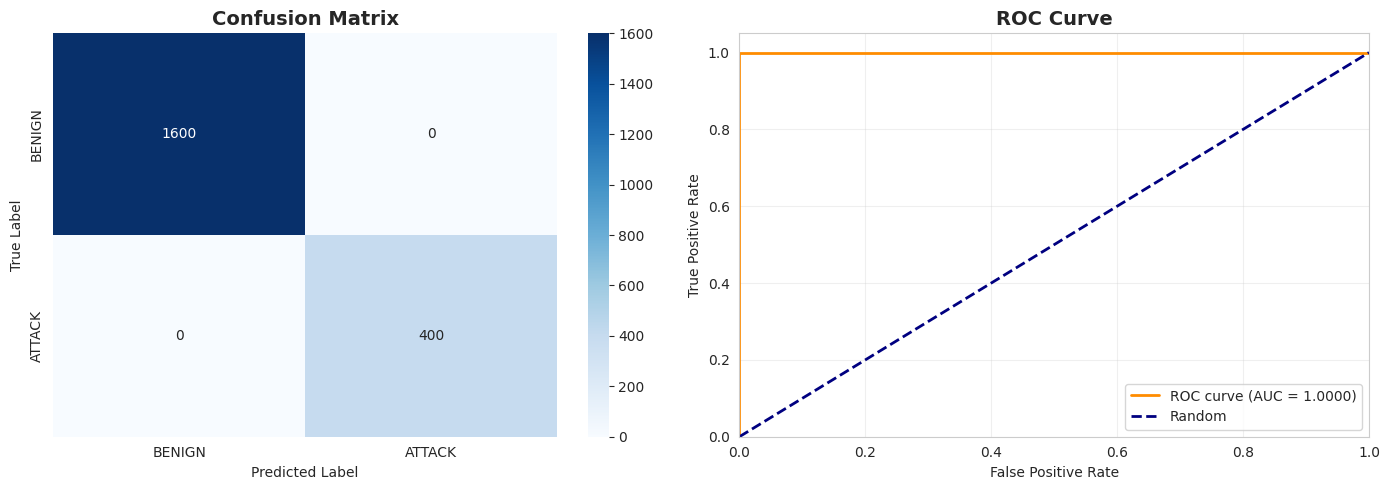


🔍 Top 10 Most Important Features:
               feature   importance
           packets_out 3.888853e+04
    window_packets_out 9.453013e+03
         total_packets 2.828974e+02
              bytes_in 7.624738e-12
             bytes_out 1.224673e-12
           total_bytes 3.945735e-13
       avg_packet_size 2.510495e-13
outbound_inbound_ratio 2.464142e-13
      window_bytes_out 2.273740e-13
             byte_rate 1.446068e-13


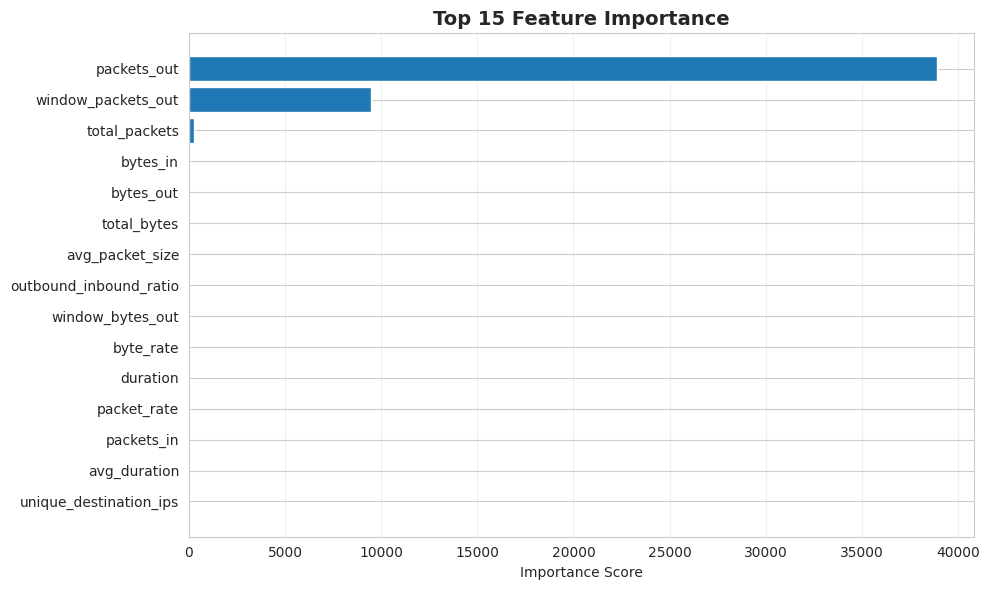

In [14]:
if y_binary is not None:
    print("\n" + "="*70)
    print("SUPERVISED LEARNING - LightGBM Classifier")
    print("="*70)

    # Train/validation/test split (60/20/20)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )

    print(f"\n📊 Data Split:")
    print(f"   Training:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"   Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"   Test:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print("\n🔧 Training LightGBM model...")

    # LightGBM parameters
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }

    # Create datasets
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    val_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

    # Train model
    supervised_model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid']
    )

    print("\n✅ Model training complete!")

    # Predictions
    y_pred_proba = supervised_model.predict(X_test_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Evaluation metrics
    print("\n" + "="*70)
    print("MODEL EVALUATION")
    print("="*70)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📈 Performance Metrics:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")

    print(f"\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['BENIGN', 'ATTACK'],
                yticklabels=['BENIGN', 'ATTACK'])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Feature importance
    print("\n🔍 Top 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'feature': FEATURE_COLUMNS,
        'importance': supervised_model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance Score')
    plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️  Skipping supervised learning - no labels available")
    supervised_model = None
    scaler = None


UNSUPERVISED LEARNING - Isolation Forest

🔧 Training Isolation Forest...
✅ Training complete!

📊 Anomaly Detection Results:
   Total samples:    10,000
   Detected anomalies: 2,000 (20.00%)
   Normal samples:     8,000 (80.00%)

📈 Performance vs Ground Truth:
   Precision: 0.2970
   Recall:    0.2970
   F1-Score:  0.2970


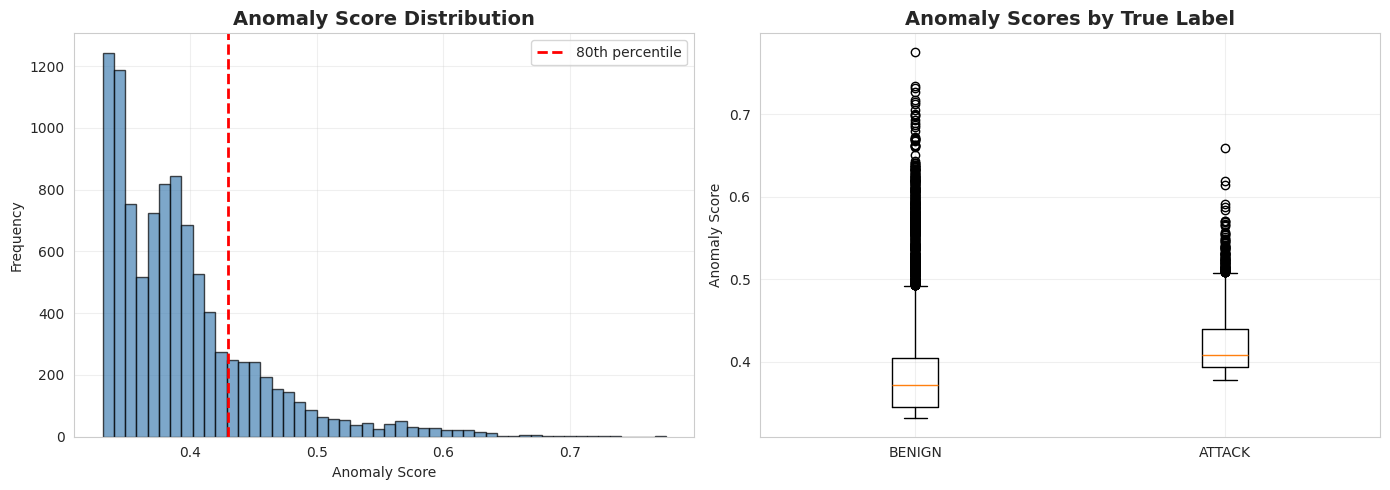


🚨 Top 5 Most Anomalous Samples:


,timestamp,bytes_in,bytes_out,total_bytes,packets_in,packets_out
5577,2026-01-29 15:29:30,835,423219,424054,28,28
3520,2026-01-29 09:46:40,34,821042,821076,22,25
1838,2026-01-29 05:06:20,415,372149,372564,24,19
1029,2026-01-29 02:51:30,576,1063425,1064001,27,12
4361,2026-01-29 12:06:50,160,242306,242466,20,22


In [15]:
print("\n" + "="*70)
print("UNSUPERVISED LEARNING - Isolation Forest")
print("="*70)

# Create scaler if not already created
if scaler is None:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = scaler.transform(X)

print("\n🔧 Training Isolation Forest...")

# Train Isolation Forest
unsupervised_model = IsolationForest(
    n_estimators=100,
    contamination=0.2,  # Expected proportion of outliers
    random_state=42,
    n_jobs=-1,
    verbose=0
)

unsupervised_model.fit(X_scaled)

print("✅ Training complete!")

# Generate anomaly scores
anomaly_scores = -unsupervised_model.score_samples(X_scaled)  # Negative for higher = more anomalous
anomaly_predictions = unsupervised_model.predict(X_scaled)  # -1 for outliers, 1 for inliers
anomaly_binary = (anomaly_predictions == -1).astype(int)  # 1 for anomaly, 0 for normal

print(f"\n📊 Anomaly Detection Results:")
print(f"   Total samples:    {len(anomaly_binary):,}")
print(f"   Detected anomalies: {anomaly_binary.sum():,} ({anomaly_binary.mean()*100:.2f}%)")
print(f"   Normal samples:     {(1-anomaly_binary).sum():,} ({(1-anomaly_binary.mean())*100:.2f}%)")

# If we have ground truth labels, evaluate performance
if y_binary is not None:
    from sklearn.metrics import precision_score, recall_score, f1_score

    precision_unsup = precision_score(y_binary, anomaly_binary)
    recall_unsup = recall_score(y_binary, anomaly_binary)
    f1_unsup = f1_score(y_binary, anomaly_binary)

    print(f"\n📈 Performance vs Ground Truth:")
    print(f"   Precision: {precision_unsup:.4f}")
    print(f"   Recall:    {recall_unsup:.4f}")
    print(f"   F1-Score:  {f1_unsup:.4f}")

# Visualize anomaly score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of anomaly scores
axes[0].hist(anomaly_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.percentile(anomaly_scores, 80), color='red', linestyle='--',
                linewidth=2, label='80th percentile')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
if y_binary is not None:
    score_data = [anomaly_scores[y_binary == 0], anomaly_scores[y_binary == 1]]
    axes[1].boxplot(score_data, labels=['BENIGN', 'ATTACK'])
    axes[1].set_ylabel('Anomaly Score')
    axes[1].set_title('Anomaly Scores by True Label', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
else:
    axes[1].boxplot([anomaly_scores], labels=['All Samples'])
    axes[1].set_ylabel('Anomaly Score')
    axes[1].set_title('Overall Anomaly Score Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Show top anomalies
print("\n🚨 Top 5 Most Anomalous Samples:")
top_anomaly_indices = np.argsort(anomaly_scores)[-5:][::-1]
top_anomalies = processed_df.iloc[top_anomaly_indices][['timestamp'] + FEATURE_COLUMNS[:5]]
display(top_anomalies)


EXPLAINABLE AI - SHAP Analysis

🔬 Initializing SHAP TreeExplainer...
   Computing SHAP values for 1000 test samples...
✅ SHAP computation complete!

📊 Global Feature Importance (SHAP)

This plot shows which features most impact the model's predictions across all samples.
Red indicates high feature values, blue indicates low feature values.



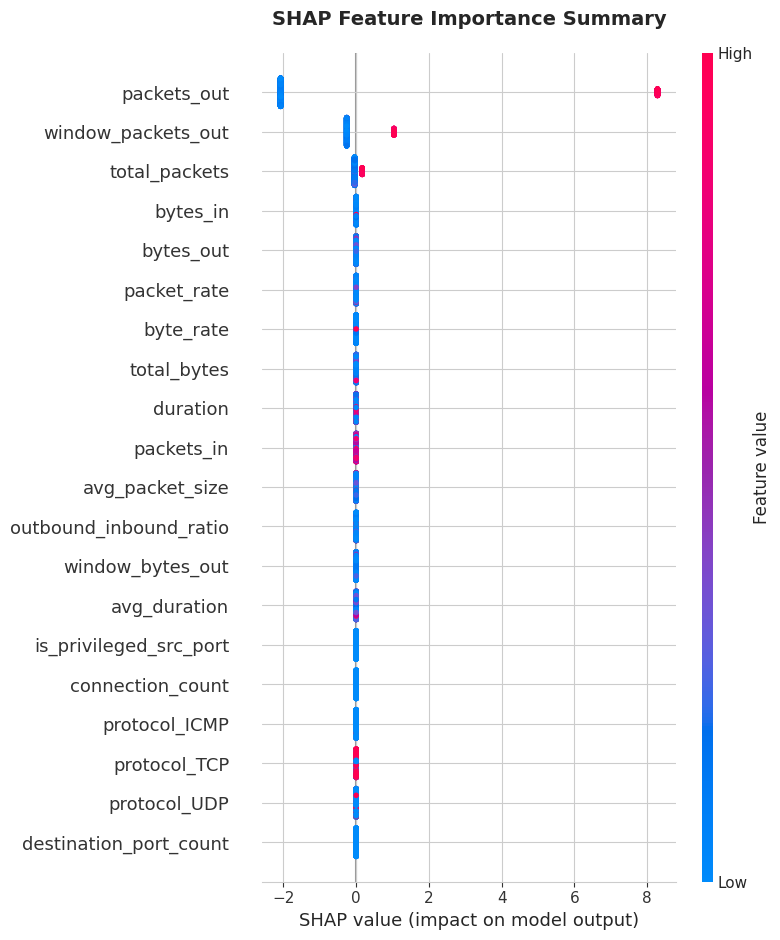


📊 Mean Absolute SHAP Values (Top 15 Features)


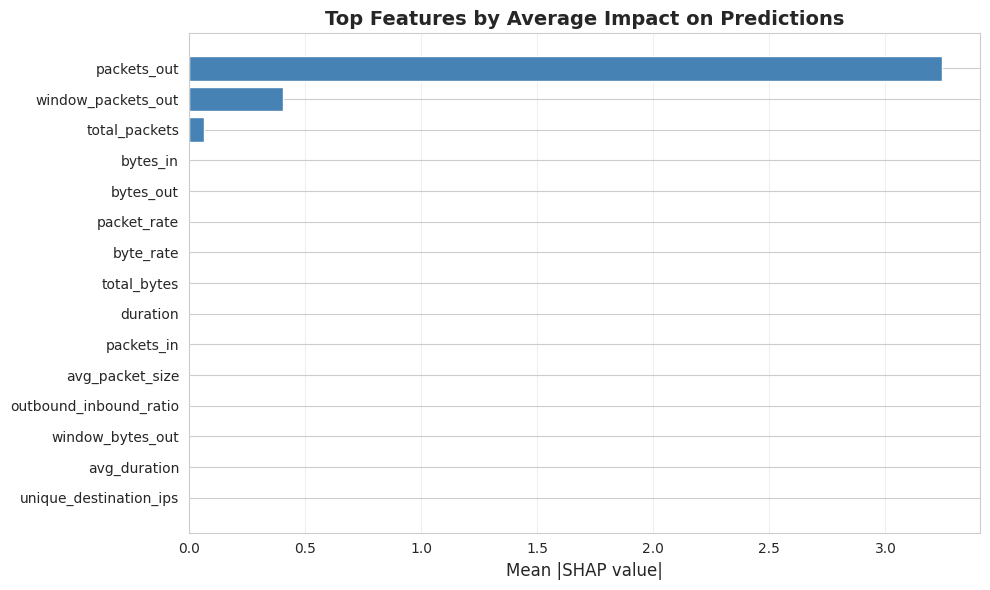


LOCAL EXPLANATION - Suspicious Sample Analysis

🎯 Analyzing sample #611
   Predicted probability of attack: 0.9948
   True label: ATTACK

📋 Top Contributing Features:

           feature     value    shap_value
       packets_out  1.201908  8.287035e+00
window_packets_out  1.194823  1.040003e+00
     total_packets  0.930847  1.671588e-01
         bytes_out -0.123056 -6.873374e-12
          bytes_in -0.184816 -6.569683e-12
       packet_rate  0.029046  5.103005e-12
         byte_rate -0.067313  3.810005e-12
   avg_packet_size -0.213642  2.426614e-12
        packets_in -1.816278 -5.943072e-13
          duration -0.792868 -3.661621e-13

📊 SHAP Waterfall Plot - How Features Push Prediction

This shows how each feature contribution adds up to the final prediction.
Red bars push toward 'Attack', blue bars push toward 'Benign'.



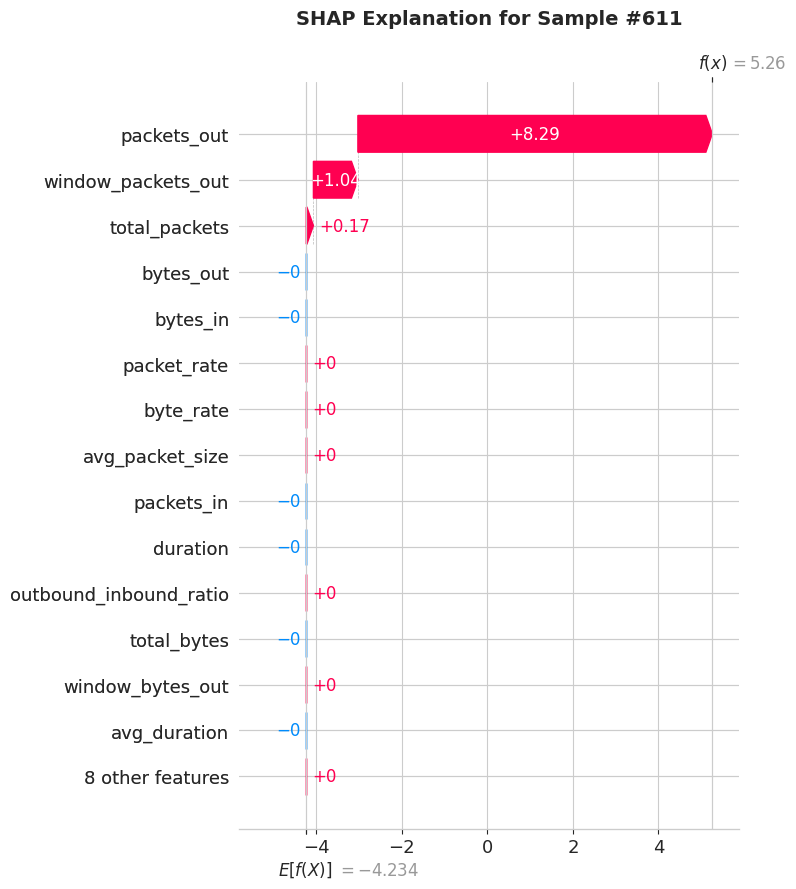


💡 Interpretation Guide:

Positive SHAP values (red) indicate features that increase attack probability.
Negative SHAP values (blue) indicate features that decrease attack probability.

For this sample, the model's decision was primarily driven by:

   • packets_out
     Value: 1.2019
     Impact: increasing attack probability by 8.2870

   • window_packets_out
     Value: 1.1948
     Impact: increasing attack probability by 1.0400

   • total_packets
     Value: 0.9308
     Impact: increasing attack probability by 0.1672


In [17]:
if supervised_model is not None:
    print("\n" + "="*70)
    print("EXPLAINABLE AI - SHAP Analysis")
    print("="*70)

    print("\n🔬 Initializing SHAP TreeExplainer...")

    # Create SHAP explainer
    explainer = shap.TreeExplainer(supervised_model)

    # Calculate SHAP values for test set (use a sample for speed)
    sample_size = min(1000, len(X_test_scaled))
    X_test_sample = X_test_scaled[:sample_size]

    print(f"   Computing SHAP values for {sample_size} test samples...")
    shap_values = explainer.shap_values(X_test_sample)

    print("✅ SHAP computation complete!")

    # Global SHAP summary plot
    print("\n📊 Global Feature Importance (SHAP)")
    print("\nThis plot shows which features most impact the model's predictions across all samples.")
    print("Red indicates high feature values, blue indicates low feature values.\n")

    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        X_test_sample,
        feature_names=FEATURE_COLUMNS,
        show=False
    )
    plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Mean absolute SHAP values (bar plot)
    print("\n📊 Mean Absolute SHAP Values (Top 15 Features)")

    shap_importance = pd.DataFrame({
        'feature': FEATURE_COLUMNS,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values('mean_abs_shap', ascending=False)

    plt.figure(figsize=(10, 6))
    top_shap = shap_importance.head(15)
    plt.barh(range(len(top_shap)), top_shap['mean_abs_shap'].values, color='steelblue')
    plt.yticks(range(len(top_shap)), top_shap['feature'].values)
    plt.xlabel('Mean |SHAP value|', fontsize=12)
    plt.title('Top Features by Average Impact on Predictions', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Local explanation for a suspicious sample
    print("\n" + "="*70)
    print("LOCAL EXPLANATION - Suspicious Sample Analysis")
    print("="*70)

    # Find a sample predicted as attack with high confidence
    attack_probs = supervised_model.predict(X_test_scaled)
    suspicious_idx = np.argmax(attack_probs)

    print(f"\n🎯 Analyzing sample #{suspicious_idx}")
    print(f"   Predicted probability of attack: {attack_probs[suspicious_idx]:.4f}")
    if y_test is not None:
        print(f"   True label: {'ATTACK' if y_test.iloc[suspicious_idx] == 1 else 'BENIGN'}")

    # Get SHAP values for this sample
    if suspicious_idx < sample_size:
        sample_shap = shap_values[suspicious_idx]
        sample_features = X_test_sample[suspicious_idx]

        # Create explanation dataframe
        explanation_df = pd.DataFrame({
            'feature': FEATURE_COLUMNS,
            'value': sample_features,
            'shap_value': sample_shap
        }).sort_values('shap_value', key=abs, ascending=False)

        print("\n📋 Top Contributing Features:")
        print("\n" + explanation_df.head(10).to_string(index=False))

        # SHAP waterfall plot for this sample
        print("\n📊 SHAP Waterfall Plot - How Features Push Prediction")
        print("\nThis shows how each feature contribution adds up to the final prediction.")
        print("Red bars push toward 'Attack', blue bars push toward 'Benign'.\n")

        plt.figure(figsize=(10, 8))
        shap.plots._waterfall.waterfall_legacy(
            explainer.expected_value,
            sample_shap,
            feature_names=FEATURE_COLUMNS,
            max_display=15,
            show=False
        )
        plt.title(f'SHAP Explanation for Sample #{suspicious_idx}',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # Interpretation notes
        print("\n💡 Interpretation Guide:")
        print("\nPositive SHAP values (red) indicate features that increase attack probability.")
        print("Negative SHAP values (blue) indicate features that decrease attack probability.")
        print("\nFor this sample, the model's decision was primarily driven by:")

        top_3 = explanation_df.head(3)
        for idx, row in top_3.iterrows():
            direction = "increasing" if row['shap_value'] > 0 else "decreasing"
            print(f"\n   • {row['feature']}")
            print(f"     Value: {row['value']:.4f}")
            print(f"     Impact: {direction} attack probability by {abs(row['shap_value']):.4f}")

    else:
        print("   (Sample not in SHAP computation set - rerun with larger sample_size)")

else:
    print("\n⚠️  SHAP analysis requires supervised model - skipped")
    explainer = None
    shap_values = None

In [18]:
print("\n" + "="*70)
print("ARTIFACT EXPORT")
print("="*70)

print("\n💾 Saving models and artifacts...")

# 1. Save supervised model
if supervised_model is not None:
    model_path = ARTIFACTS_PATH / 'supervised_model.txt'
    supervised_model.save_model(str(model_path))
    print(f"   ✓ Supervised model saved: {model_path}")

# 2. Save unsupervised model
unsupervised_model_path = ARTIFACTS_PATH / 'unsupervised_model.joblib'
joblib.dump(unsupervised_model, unsupervised_model_path)
print(f"   ✓ Unsupervised model saved: {unsupervised_model_path}")

# 3. Save scaler
scaler_path = ARTIFACTS_PATH / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"   ✓ Scaler saved: {scaler_path}")

# 4. Save label encoder (if exists)
if label_encoder is not None:
    encoder_path = ARTIFACTS_PATH / 'label_encoder.joblib'
    joblib.dump(label_encoder, encoder_path)
    print(f"   ✓ Label encoder saved: {encoder_path}")

# 5. Save SHAP explainer background data
if explainer is not None:
    shap_bg_path = ARTIFACTS_PATH / 'shap_background_data.npy'
    np.save(shap_bg_path, X_test_sample)
    print(f"   ✓ SHAP background data saved: {shap_bg_path}")

    # Save sample SHAP values
    shap_values_path = ARTIFACTS_PATH / 'sample_shap_values.npy'
    np.save(shap_values_path, shap_values)
    print(f"   ✓ Sample SHAP values saved: {shap_values_path}")

# 6. Save comprehensive metadata
metadata = {
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_samples': len(X),
        'n_features': len(FEATURE_COLUMNS),
        'feature_names': FEATURE_COLUMNS,
        'has_labels': y is not None
    },
    'models': {
        'supervised': {
            'type': 'LightGBM',
            'trained': supervised_model is not None,
            'path': str(model_path) if supervised_model is not None else None
        },
        'unsupervised': {
            'type': 'IsolationForest',
            'trained': True,
            'path': str(unsupervised_model_path),
            'contamination': 0.2
        }
    },
    'preprocessing': {
        'scaler_path': str(scaler_path),
        'label_encoder_path': str(encoder_path) if label_encoder is not None else None,
        'label_mapping': label_mapping
    },
    'explainability': {
        'shap_available': explainer is not None,
        'shap_bg_data_path': str(shap_bg_path) if explainer is not None else None,
        'sample_shap_path': str(shap_values_path) if explainer is not None else None
    }
}

if supervised_model is not None:
    metadata['performance'] = {
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc)
    }

metadata_path = ARTIFACTS_PATH / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"   ✓ Metadata saved: {metadata_path}")

# 7. Create a README for the artifacts
readme_content = """# IDS ML Pipeline Artifacts

## Generated Artifacts

This directory contains trained models and artifacts from the IDS ML pipeline.

### Files:

1. **supervised_model.txt** - Trained LightGBM binary classifier
2. **unsupervised_model.joblib** - Trained Isolation Forest for anomaly detection
3. **scaler.joblib** - StandardScaler for feature normalization
4. **label_encoder.joblib** - LabelEncoder for attack type labels
5. **shap_background_data.npy** - Background data for SHAP explanations
6. **sample_shap_values.npy** - Pre-computed SHAP values for reference
7. **model_metadata.json** - Comprehensive metadata about models and performance

### Usage in Dashboard:

```python
import joblib
import lightgbm as lgb
import numpy as np

# Load models
supervised_model = lgb.Booster(model_file='supervised_model.txt')
unsupervised_model = joblib.load('unsupervised_model.joblib')
scaler = joblib.load('scaler.joblib')

# Load metadata
with open('model_metadata.json', 'r') as f:
    metadata = json.load(f)
    feature_names = metadata['dataset_info']['feature_names']

# Make prediction
def predict(features):
    features_scaled = scaler.transform([features])
    attack_prob = supervised_model.predict(features_scaled)[0]
    anomaly_score = -unsupervised_model.score_samples(features_scaled)[0]
    return attack_prob, anomaly_score
```

### SHAP Integration:

```python
import shap

# Create explainer
explainer = shap.TreeExplainer(supervised_model)

# Get explanation for new sample
shap_values = explainer.shap_values(features_scaled)
```

Generated: """ + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

readme_path = ARTIFACTS_PATH / 'README.md'
with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"   ✓ README saved: {readme_path}")

print("\n" + "="*70)
print("✅ All artifacts exported successfully!")
print("="*70)
print(f"\n📁 Artifacts location: {ARTIFACTS_PATH}")
print("\n   These artifacts are ready for integration with your dashboard.")


ARTIFACT EXPORT

💾 Saving models and artifacts...
   ✓ Supervised model saved: /content/drive/MyDrive/ids_project/artifacts/supervised_model.txt
   ✓ Unsupervised model saved: /content/drive/MyDrive/ids_project/artifacts/unsupervised_model.joblib
   ✓ Scaler saved: /content/drive/MyDrive/ids_project/artifacts/scaler.joblib
   ✓ Label encoder saved: /content/drive/MyDrive/ids_project/artifacts/label_encoder.joblib
   ✓ SHAP background data saved: /content/drive/MyDrive/ids_project/artifacts/shap_background_data.npy
   ✓ Sample SHAP values saved: /content/drive/MyDrive/ids_project/artifacts/sample_shap_values.npy
   ✓ Metadata saved: /content/drive/MyDrive/ids_project/artifacts/model_metadata.json
   ✓ README saved: /content/drive/MyDrive/ids_project/artifacts/README.md

✅ All artifacts exported successfully!

📁 Artifacts location: /content/drive/MyDrive/ids_project/artifacts

   These artifacts are ready for integration with your dashboard.


In [19]:
print("\n" + "="*70)
print("ARTIFACT VALIDATION")
print("="*70)

print("\n🔄 Loading saved artifacts...")

# Load models
if supervised_model is not None:
    loaded_supervised_model = lgb.Booster(model_file=str(ARTIFACTS_PATH / 'supervised_model.txt'))
    print("   ✓ Supervised model loaded")
else:
    loaded_supervised_model = None

loaded_unsupervised_model = joblib.load(ARTIFACTS_PATH / 'unsupervised_model.joblib')
print("   ✓ Unsupervised model loaded")

loaded_scaler = joblib.load(ARTIFACTS_PATH / 'scaler.joblib')
print("   ✓ Scaler loaded")

# Load metadata
with open(ARTIFACTS_PATH / 'model_metadata.json', 'r') as f:
    loaded_metadata = json.load(f)
print("   ✓ Metadata loaded")

print("\n✅ All artifacts loaded successfully!")

# Test inference on a random sample
print("\n" + "="*70)
print("INFERENCE TEST")
print("="*70)

# Select a random sample
test_idx = np.random.randint(0, len(X))
test_sample = X.iloc[test_idx:test_idx+1]

print(f"\n🎯 Testing on sample #{test_idx}")
print("\n📋 Sample Features:")
for feat, val in test_sample.iloc[0].items():
    print(f"   {feat}: {val:.4f}")

# Scale features
test_sample_scaled = loaded_scaler.transform(test_sample)

# Supervised prediction
if loaded_supervised_model is not None:
    attack_probability = loaded_supervised_model.predict(test_sample_scaled)[0]
    prediction_label = "ATTACK" if attack_probability > 0.5 else "BENIGN"
    confidence = attack_probability if attack_probability > 0.5 else 1 - attack_probability

    print("\n" + "="*70)
    print("SUPERVISED MODEL PREDICTION")
    print("="*70)
    print(f"\n   Prediction: {prediction_label}")
    print(f"   Attack Probability: {attack_probability:.4f}")
    print(f"   Confidence: {confidence:.4f}")

    if y is not None:
        true_label = "ATTACK" if features_df.iloc[test_idx]['label'] != 'BENIGN' else "BENIGN"
        correct = "✅" if prediction_label == true_label else "❌"
        print(f"   True Label: {true_label} {correct}")

# Unsupervised prediction
anomaly_score = -loaded_unsupervised_model.score_samples(test_sample_scaled)[0]
is_anomaly = loaded_unsupervised_model.predict(test_sample_scaled)[0] == -1

print("\n" + "="*70)
print("UNSUPERVISED MODEL PREDICTION")
print("="*70)
print(f"\n   Anomaly Score: {anomaly_score:.4f}")
print(f"   Is Anomaly: {'YES' if is_anomaly else 'NO'}")

# SHAP explanation for this sample
if loaded_supervised_model is not None and explainer is not None:
    print("\n" + "="*70)
    print("SHAP EXPLANATION")
    print("="*70)

    # Compute SHAP values
    sample_shap_values = explainer.shap_values(test_sample_scaled)

    # Get top contributing features
    feature_contributions = pd.DataFrame({
        'feature': FEATURE_COLUMNS,
        'value': test_sample.iloc[0].values,
        'shap_value': sample_shap_values[0]
    }).sort_values('shap_value', key=abs, ascending=False)

    print("\n🔍 Top 5 Contributing Features:")
    print()
    for idx, row in feature_contributions.head(5).iterrows():
        impact = "increases" if row['shap_value'] > 0 else "decreases"
        print(f"   {row['feature']}")
        print(f"     Value: {row['value']:.4f}")
        print(f"     SHAP: {row['shap_value']:+.4f} ({impact} attack probability)")
        print()

print("\n" + "="*70)
print("✅ VALIDATION COMPLETE")
print("="*70)
print("\nThe inference pipeline is working correctly!")
print("Models and artifacts are ready for production deployment.")


ARTIFACT VALIDATION

🔄 Loading saved artifacts...
   ✓ Supervised model loaded
   ✓ Unsupervised model loaded
   ✓ Scaler loaded
   ✓ Metadata loaded

✅ All artifacts loaded successfully!

INFERENCE TEST

🎯 Testing on sample #7741

📋 Sample Features:
   bytes_in: 208.0000
   bytes_out: 8284.0000
   total_bytes: 8492.0000
   packets_in: 26.0000
   packets_out: 20.0000
   total_packets: 46.0000
   avg_packet_size: 184.6087
   outbound_inbound_ratio: 39.8269
   packet_rate: 6.6868
   byte_rate: 1234.4373
   unique_destination_ips: 1.0000
   destination_port_count: 1.0000
   window_packets_out: 20.0000
   window_bytes_out: 8284.0000
   avg_duration: 6.8792
   is_common_dst_port: 1.0000
   is_privileged_src_port: 0.0000
   connection_count: 1.0000
   duration: 6.8792
   protocol_ICMP: 1.0000
   protocol_TCP: 0.0000
   protocol_UDP: 0.0000

SUPERVISED MODEL PREDICTION

   Prediction: BENIGN
   Attack Probability: 0.0013
   Confidence: 0.9987
   True Label: BENIGN ✅

UNSUPERVISED MODEL PREDI